# 프로젝트 : 뉴스기사 요약해보기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


# 1. 데이터 수집하기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
89030,Lightning kills 7 people including 3 infants i...,At least 7 people were killed and two injured ...
94115,Govt plans to fix quantity of food served in r...,The Centre is planning to fix the quantity of ...
93712,President Pranab Mukherjee clears all four GST...,President Pranab Mukherjee on Thursday cleared...
84103,Man steals mummified human toe served in iconi...,A guest at a Canadian bar allegedly stole a mu...
86338,Tubelight won't break records of Baahubali 2: ...,Actor Salman Khan has said that his upcoming f...
38834,England 1st world no. 1 team to lose to an ass...,England on Sunday became the first team in cri...
2272,LIC's market share falls below 70% in FY18,The market share of state-owned Life Insurance...
89598,FBI Director James Comey thought his firing wa...,"FBI Director James Comey, who was fired by US ..."
77602,Saudi Arabia asks US court to end lawsuits ove...,Saudi Arabia on Tuesday asked a US court to di...
6207,Malaysian fugitive's yacht goes on sale at hal...,"Superyacht 'Equanimity', once owned by fugitiv..."


In [4]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


---

# 2. 데이터 전처리하기 (추상적 요약)

### 1) 중복 제거

In [5]:
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [7]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('중복 제거한 전체 샘플수 :', (len(data)))

중복 제거한 전체 샘플수 : 98360


### 2) Null 제거

In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


#### 각 항목에 null은 없습니다.

### 3) 불용어(stopwords) + 전처리

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, "lxml").text
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = re.sub('"','', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","", sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = re.sub('[m]{2,}', 'mm', sentence)
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [11]:
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [12]:
clean_headlines = []

for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("Headlines 전처리 후 결과: ", clean_headlines[:5])

Headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [13]:
data['text'] = clean_text
data['headlines'] = clean_headlines

#### 빈 값이 생겼는지 확인

In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

#### 확인 결과, 빈 값은 발생하지 않았습니다.

### 4) 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


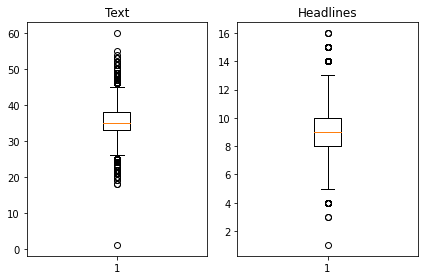

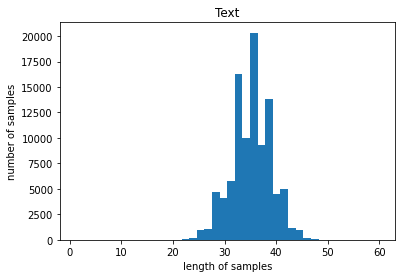

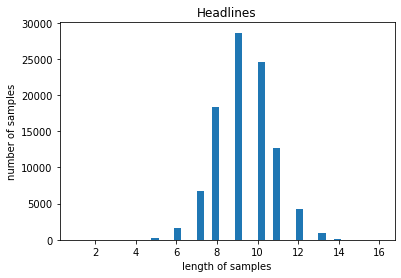

In [15]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### Text
- Text의 경우 최소 길이가 1, 최대 길이가 60 입니다
- 평균 길이는 35
- 시각화된 그래프로 봤을 때는 대체적으로는 분포가 주로 45 내외의 길이를 가지는 걸 알 수 있음

#### Headlines
- Headlines의 경우 최소 길이가 1, 최대 길이가 15, 그리고 평균 길이가 9
- Text에 비해 상대적으로 길이가 매우 짧습니다.
- 그래프로 봤을 때에도 대체적으로 11 이하의 길이를 가지고 있음

In [16]:
text_max_len = 45
headlines_max_len = 11
print('=3')

=3


In [17]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [19]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 92656


### 5) 시작 토큰과 종료 토큰 추가하기

In [20]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


#### 데이터 섞기

In [21]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices) # Text 갯수만큼의 인덱스들을 섞어서 준비

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2) # 20%
print('테스트 데이터의 수 :', n_of_val, '\n')

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

[ 9072 58870 70764 ... 24122 62210 42130]
테스트 데이터의 수 : 18531 

훈련 데이터의 개수 : 74125
훈련 레이블의 개수 : 74125
테스트 데이터의 개수 : 18531
테스트 레이블의 개수 : 18531


### 6) text 정수 인코딩 (단어사전, 희귀단어 제거)

In [22]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)
print('=3')

=3


In [23]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key,value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68154
등장 빈도가 6번 이하인 희귀 단어의 수: 46520
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21634
단어 집합에서 희귀 단어의 비율: 68.25718226369692
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.629210688292481


- 등장 빈도가 threshold 값인 6회 이하인 단어들은 단어 집합에서 68% 이상을 차지하지만
- 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.6%밖에 되지 않음

In [24]:
src_vocab = 21000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 21000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [25]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[880, 1335, 839, 49, 296, 1944, 173, 472, 490, 119, 30, 482, 1792, 839, 116, 253, 72, 304, 22, 11, 484, 5043, 9162, 18, 47, 139, 12, 2583, 146, 119, 10899, 2583], [683, 97, 1721, 45, 188, 300, 2168, 1133, 160, 34, 174, 198, 3441, 665, 1, 1039, 946, 10900, 544, 16, 2236, 840, 3333, 2255, 1721, 364, 333], [4668, 13872, 150, 259, 3374, 18949, 1989, 15561, 3, 284, 195, 445, 2716, 8658, 20123, 60, 2771, 715, 402, 3719, 2, 103, 4166, 703, 6, 1, 7002, 8, 404, 3924, 259, 1316]]


### 7) headlines 정수 인코딩 (단어사전, 희귀단어 제거)

In [26]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [29]:
threshold = 4
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key,value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29582
등장 빈도가 3번 이하인 희귀 단어의 수: 16724
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 12858
단어 집합에서 희귀 단어의 비율: 56.53437901426543
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.363607892264328


- 등장 빈도가 threshold 값인 4회 이하인 단어들은 단어 집합에서 56% 이상을 차지하지만
- 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.3%밖에 되지 않음

In [30]:
tar_vocab = 12000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 376, 357, 500, 5, 1411, 5, 231, 238, 54], [1, 1165, 4995, 1772, 790], [1, 7937, 3853, 3, 2671, 239, 2342, 5, 11274], [1, 5425, 395, 9289, 82, 4, 2392, 2976], [1, 3434, 60, 23, 1478, 3740, 3, 1833, 3336, 1591, 2297]]
target
decoder  [[376, 357, 500, 5, 1411, 5, 231, 238, 54, 2], [1165, 4995, 1772, 790, 2], [7937, 3853, 3, 2671, 239, 2342, 5, 11274, 2], [5425, 395, 9289, 82, 4, 2392, 2976, 2], [3434, 60, 23, 1478, 3740, 3, 1833, 3336, 1591, 2297, 2]]


### 8) 희귀단어 제거 이후, 길이가 0이 된 샘플들은 제거

In [31]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 74125
훈련 레이블의 개수 : 74125
테스트 데이터의 개수 : 18531
테스트 레이블의 개수 : 18531


### 9) 패딩 추가

In [33]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


---

# 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [34]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention


embedding_dim = 128
hidden_size = 256


# 인코더 설계
encoder_inputs = Input(shape=(text_max_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)


# 디코더 설계
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])


# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

attn_out = attn_layer([decoder_outputs, encoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)


# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2688000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [35]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
290/290 [==============================] - 196s 621ms/step - loss: 6.1634 - val_loss: 5.7552
Epoch 2/50
290/290 [==============================] - 180s 619ms/step - loss: 5.5555 - val_loss: 5.3196
Epoch 3/50
290/290 [==============================] - 180s 620ms/step - loss: 5.2039 - val_loss: 5.0364
Epoch 4/50
290/290 [==============================] - 180s 620ms/step - loss: 4.9195 - val_loss: 4.8206
Epoch 5/50
290/290 [==============================] - 180s 620ms/step - loss: 4.6929 - val_loss: 4.6804
Epoch 6/50
290/290 [==============================] - 179s 618ms/step - loss: 4.5089 - val_loss: 4.5681
Epoch 7/50
290/290 [==============================] - 178s 614ms/step - loss: 4.3528 - val_loss: 4.4626
Epoch 8/50
290/290 [==============================] - 179s 616ms/step - loss: 4.2135 - val_loss: 4.3880
Epoch 9/50
290/290 [==============================] - 177s 612ms/step - loss: 4.0927 - val_loss: 4.3145
Epoch 10/50
290/290 [==============================] - 178s 613m

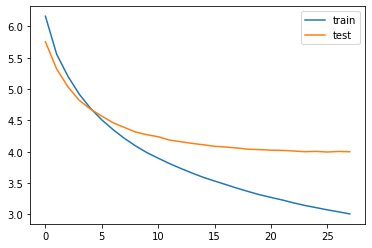

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

##### 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인했습니다

---

# 4. 실제 결과와 요약문 비교하기 (추상적 요약)

### 인퍼런스 모델 구현

In [37]:
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

In [38]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [39]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence


# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp


# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [42]:
for i in range(50, 60):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : bjp president amit shah tuesday said mandate delhi nation mandate people india firmly pm modi shah said target win mcd election built base formation bjp government delhi 
실제 요약 : delhi civic body mandate is nation mandate amit shah 
예측 요약 :  pm modi has no role in shah in shah


원문 : marathi film producer atul sunday allegedly committed suicide pune hotel consuming poison per preliminary investigation earlier written facebook post marathi citing financial loss filmmaking family disputes reasons suicide film dhol though appreciated political plot performed well box office 
실제 요약 : marathi film producer ends life posts suicide note on fb 
예측 요약 :  kannada actor producer arrested for cheating in film


원문 : death toll risen nine violence bharat bandh called dalit groups protest supreme court ruling sc st act six victims madhya pradesh two uttar pradesh one rajasthan clashes police forces damage government property roads trains reported across states 
실제 요약 : death toll rises to nine 

---

# 5. Summa을 이용해서 추출적 요약해보기

- data 데이터 전처리 (불용어, 정규화까지) 다시 진행 후 추출적 요약 처리

In [63]:
import urllib.request
from summa.summarizer import summarize

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
extractiveData = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

extractiveData.sample(10)

,headlines,text
95978,Odisha teacher thrashed for sexually assaultin...,Villagers beat up a school teacher in Odisha's...
19,Odisha CM Patnaik controls mining mafia: Union...,Union Minister Dharmendra Pradhan on Wednesday...
85934,'Everything' becomes 1st video game to qualify...,"Animated video game, 'Everything', by filmmake..."
30112,Preity Zinta apologises as KXIP fail to qualif...,KXIP owner Preity Zinta on Monday took to Twit...
36152,"Andhra university site hacked, Pak Zindabad sl...",Andhra University's official website was alleg...
13495,Idol of Goddess decorated with Ã¢ÂÂ¹4 cr cash...,"On the occasion of Navaratri, the idol of Godd..."
9407,Video shows Madhuri paying tribute to Sridevi ...,A video shows Madhuri Dixit dancing on late ac...
79654,Kamal asks fans to mail corruption complaint t...,Actor Kamal Haasan on Twitter urged his fans t...
59158,95-yr-old woman declared 'dead' casts vote in ...,A 95-year-old woman cast her vote in Uttar Pra...
44526,"Taapsee, Saqib starrer 'Dil Juunglee' hits the...",Taapsee Pannu and Saqib Saleem starrer 'Dil Ju...


### 원문의 0.5%만을 출력하도록 설정

In [74]:
extractiveData['text5summary'] = extractiveData['text'].apply(lambda x: summarize(x, ratio=0.5))

In [75]:
extractiveData['text5summary'].head()

0    upGrad's Online Power Learning has powered 3 l...
1    Users get one CRED coin per rupee of bill paid...
2    The match witnessed India getting all out for ...
3    Also, customers have options to insure against...
4    Speaking about the sexual harassment allegatio...
Name: text5summary, dtype: object

### 단어의 수로 요약문의 크기를 설정

In [76]:
extractiveData['text50words'] = extractiveData['text'].apply(lambda x: summarize(x, words=15))

In [77]:
extractiveData['text50words'].head()

0    upGrad's Online Power Learning has powered 3 l...
1    Users get one CRED coin per rupee of bill paid...
2    The match witnessed India getting all out for ...
3    Also, customers have options to insure against...
4                                                     
Name: text50words, dtype: object

---
# 추상적 요약과 추출적 요약 분석 결과

### 추상적 요약 분석

In [56]:
for i in range(0, 5):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : town colorado us passed ordinance requiring every household gun members town board voted favour ordinance inspired family protection ordinance passed town georgia ordinance provides emergency management general safety residents 
실제 요약 : town in requires every household to own gun 
예측 요약 :  us embassy in law to be used to protect chicken


원문 : role charlie mother biopic titled played real life daughter known silent political english actor made film debut movie making living actor whose th death anniversary observed monday received honorary oscar 
실제 요약 : charlie daughter played his mother in his biopic 
예측 요약 :  sridevi daughter to play mother in biopic


원문 : welsh international gareth bale scored left footed bicycle kick real madrid minutes coming substitute final champions league saturday bale followed long range effort liverpool goalkeeper concede goal bale later called bicycle kick goal best goal career 
실제 요약 : watch bale bicycle kick that won real madrid the cl title 
예측 요약

추상적 요약 결과 특징을 정리하면 다음과 같습니다. 

#### 문법 완성도가 떨어집니다. 
1. 주어에 있으면 안되는 단어가 주어에 위치함
2. 데이터 전처리로 인해 특수문자가 없어서 소유격과 같은 단어구성이 떨어짐

#### 핵심 단어를 (낮은 비율로) 포함합니다.
낮은 비율이긴 하지만 핵심단어를 포함합니다. 
- 어떤 문장에서는 "누군가의 daughter", "play(연기하다)" 핵심 단어가 포함되는 것을 찾을 수 있습니다. (문법은 여전히 틀림)
    ```
    실제 요약 : charlie daughter played his mother in his biopic 
    예측 요약 :  sridevi daughter to play mother in biopic
    ```
- 그러나 어떤 문장에서 전혀 상관없는 단어들로 구성되기도 합니다.
    ```
    실제 요약 : town in requires every household to own gun 
    예측 요약 :  us embassy in law to be used to protect chicken
    ```


### 추출적 요약 분석

In [81]:
for i in range(0, 5):
    print("원문 :", extractiveData['text'].iloc[i])
    print("\n실제 요약 :", extractiveData['headlines'].iloc[i])
    print("\n0.5% 출력 :", extractiveData['text5summary'].iloc[i])
    print("\n단어 15개 출력 : ", extractiveData['text50words'].iloc[i])
    
    print('\n\n')

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike

0.5% 출력 : upGrad's Online Power Learning has powered 3 lakh+ careers.

단어 15개 출력 :  upGrad's Online Power Learning has powered 3 lakh+ careers.



원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.

실제 요약 : Delhi techie wins free food from S

추출적 요약 결과 특징을 정리하면 다음과 같습니다. 

#### 문법 완성도가 높습니다.
1. 주술목 모두 적절한 위치에 있습니다.
2. 원문의 문장을 활용하기 때문에 문장 구성이 알맞습니다.

#### 핵심 단어를 포함하지 못합니다.
- 추출적 요약은 원문에서 요약할 문장을 꼽는 형태로 결과를 출력합니다. 그러나 출력한 문장이 핵심 단어를 포함하는 경우는 적고, 실제 요약 결과와 전혀 다른 문장을 보여줍니다.

---

# 회고

### 1. 어려웠던 점
- 학습하는데 시간이 오래 걸렸던 점이 쉽지 않았습니다. 원본 텍스트의 max_len 설정을 변경하면서 실험해보고 싶었는데.. 학습이 너무 오래걸려 (시간 관계상) 하지 못했습니다.


### 2. 시도한 것들
- 정수 인코딩에 적절한 범위를 찾기 위해 값을 수정해봤습니다.
- 데이터 전처리에 몇가지 특수기호를 제거하도록 적용해보기도 했었습니다만, 결과에 큰 차이가 없었습니다.


### 3. 자기 다짐
```
막판에 제출 마감에 쫓겨 시간적 여유가 없어서 시도하지 못한 부분들이 아쉽습니다. 다음에는 연휴라고 손 놓지말고 미리미리.. 시간날때 천천히 모델학습 돌려놓으면서 과제 수행해야겠다고 다짐하게 됐습니다.
```
